In this document, we show how to use a regression model to make fault detection. The basic idea is to calculate the residual error of the regression model prediction and the measurement value. If the residual error is large, it means that the model prediction is not accurate and the measurement value is likely to be faulty.

## Prepare data

First, we read all the data and apply a simply outlier removal by validity range.

In [9]:
from utility import read_all_test_data_from_path
import numpy as np
import pandas as pd


def remove_outliers(df: pd.DataFrame):
    ''' # Description
    Remove outliers from the dataframe based on defined valid ranges. 
    Define a valid range of temperature and voltage. 
    Use ffil function to replace the invalid measurement with the previous value.
    '''
    df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
    df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
    df['temperature'] = df['temperature'].ffill()
    df['temperature'] = df['temperature'] - df['temperature'].iloc[0]

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].where(df['voltage'] <= 9000, np.nan)
    df['voltage'] = df['voltage'].ffill()
    df['voltage'] = df['voltage'] - df['voltage'].iloc[0]

    df['position'] = df['position'].where(df['position'] >= 0, np.nan)
    df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
    df['position'] = df['position'].ffill()
    df['position'] = df['position'] - df['position'].iloc[0]


base_dictionary = '../../dataset/training_data/'
df_data = read_all_test_data_from_path(base_dictionary, remove_outliers, is_plot=False)

Then, we use all the normal tests as training data, and use these data to fit a regression model.

In [10]:
from utility import extract_selected_feature, prepare_sliding_window

# Get all the normal data.
normal_test_id = ['20240105_164214', 
    '20240105_165300', 
    '20240105_165972', 
    '20240320_152031', 
    '20240320_153841', 
    '20240320_155664', 
    '20240321_122650', 
    '20240325_135213', 
    '20240426_141190', 
    '20240426_141532', 
    '20240426_141602', 
    '20240426_141726', 
    '20240426_141938', 
    '20240426_141980', 
    '20240503_164435']

# # Get all the normal data with operation mode 'not moving'.
# normal_test_id = [
#     '20240105_164214',
#     '20240105_165972',
#     '20240320_152031',
#     '20240320_155664',
#     '20240325_135213'
# ]

# normal_test_id = [
#     '20240325_135213'
# ]

df_tr = df_data[df_data['test_condition'].isin(normal_test_id)]

# Select the features.
# Use all the features.
# feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
#                     'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
#                     'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
#                     'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
#                     'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
#                     'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']
feature_list_all = ['time', 'data_motor_1_position', 
                    'data_motor_2_position', 
                    'data_motor_3_position', 
                    'data_motor_4_position', 
                    'data_motor_5_position', 
                    'data_motor_6_position', 'data_motor_6_temperature']
# Prepare feature and response of the training dataset.
x_tr_org, y_temp_tr_org = extract_selected_feature(df_data=df_tr, feature_list=feature_list_all, motor_idx=6, mdl_type='reg')

# Enrich the features based on the sliding window.
window_size = 100
sample_step = 10
prediction_lead_time = 1

x_tr, y_temp_tr = prepare_sliding_window(df_x=x_tr_org, y=y_temp_tr_org, window_size=window_size, sample_step=sample_step, prediction_lead_time=prediction_lead_time, mdl_type='reg')

## Fit the regression model

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('regressor', LinearRegression())    # Step 2: Linear Regression
]

# Create the pipeline
mdl_linear_regreession = Pipeline(steps)
# Fit the model
mdl = mdl_linear_regreession.fit(x_tr, y_temp_tr)

## KNN regression

In [12]:
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn import neighbors

# knn = neighbors.KNeighborsRegressor(n_neighbors=5, weights='distance')
# # Define the steps of the pipeline
# steps = [
#     ('standardizer', StandardScaler()),  # Step 1: StandardScaler
#     ('regressor', knn)    # Step 2: Linear Regression
# ]

# # Create the pipeline
# mdl_linear_regreession = Pipeline(steps)
# # Fit the model
# mdl = mdl_linear_regreession.fit(x_tr, y_temp_tr)

## Ridge regression

In [13]:
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import Ridge

# # Define the steps of the pipeline
# steps = [
#     ('standardizer', StandardScaler()),  # Step 1: StandardScaler
#     ('regressor', Ridge(alpha=.5))    # Step 2: Linear Regression
# ]

# # Create the pipeline
# mdl_linear_regreession = Pipeline(steps)
# # Fit the model
# mdl = mdl_linear_regreession.fit(x_tr, y_temp_tr)

## Prepare testing data

In [14]:
# We use all the sequence from motor 6 with failure labels as test data.
test_id = [
    '20240325_155003',
    '20240425_093699',
    '20240425_094425',
    '20240426_140055',
    '20240503_163963',
    '20240503_164675',
    '20240503_165189'
]

# test_id = [
#     '20240425_093699',
#     '20240425_094425',
#     '20240426_140055',
#     '20240503_163963',
#     '20240503_164675',
#     '20240503_165189'
# ]

# # Operation mode 'not moving'
# test_id = [
#     '20240425_093699',
#     '20240425_094425',
#     '20240426_140055'
# ]

# # Operation mode 'move only motor 6'
# test_id = [
#     '20240503_164675', 
#     '20240503_165189'
# ]

# # Operation mode 'pick up and place'
# test_id = [
#     # '20240503_163963'
#     '20240325_155003'
# ]

df_test = df_data[df_data['test_condition'].isin(test_id)]

# # Get labels.
# x_test, y_label_test = extract_selected_feature(df_data=df_test, feature_list=feature_list_all, motor_idx=6, mdl_type='clf')
# _, y_label_test = prepare_sliding_window(df_x=x_test, y=y_label_test, sequence_name_list=test_id, window_size=window_size, sample_step=sample_step, prediction_lead_time=prediction_lead_time, mdl_type='clf')

# # Prepare test data.
# x_test, y_temp_test = extract_selected_feature(df_data=df_test, feature_list=feature_list_all, motor_idx=6, mdl_type='reg')
# # x_test, y_temp_test = prepare_sliding_window(df_x=x_test, y=y_temp_test, sequence_name_list=test_id, window_size=window_size, sample_step=sample_step, prediction_lead_time=prediction_lead_time, mdl_type='reg')

In [19]:
from utility import show_reg_result, show_clf_result, concatenate_features
import numpy as np
import copy
from tqdm import tqdm


def predict_label_by_reg(mdl, df_x_test, y_temp_test, window_size, sample_step, prediction_lead_time, threshold=.05):
    # If no sequence_list is given, extract all the unique values from 'test_condition'.
    sequence_name_list = df_x_test['test_condition'].unique().tolist()

    y_label_pred = []
    y_temp_pred = []

    # Process sequence by sequence.
    for name in tqdm(sequence_name_list):
        # Extract one sequence.
        df_x_test_seq = df_x_test[df_x_test['test_condition']==name]
        y_temp_test_seq = y_temp_test[df_x_test['test_condition']==name]        
    
        y_temp_local = copy.deepcopy(y_temp_test_seq)

        # Initial values of the prediction.
        # Length is len - window_size + 1 because we need to use the sliding window to define features.
        y_label_pred_tmp = np.zeros(len(df_x_test_seq)-window_size+1) # Predicted label.
        y_temp_pred_tmp = np.zeros(len(df_x_test_seq)-window_size+1) # Predicted temperature.
        
        # Making the prediction using a sequential approach.
        for i in range(window_size, len(df_x_test_seq)+1):
            # Get the data up to current moment i-1.
            tmp_df_x = df_x_test_seq.iloc[i-window_size:i, :]
            tmp_y_temp_measure = y_temp_local.iloc[i-window_size:i]

            # Use the same sliding window to generate features.
            feature_x, _ = concatenate_features(df_input=tmp_df_x, y_input=tmp_y_temp_measure, X_window=[], y_window=[], 
                     window_size=window_size, sample_step=sample_step, prediction_lead_time=prediction_lead_time, mdl_type='reg')
            # Create a dataframe for the new features
            # feature_x = pd.DataFrame(feature_x)
            
            # Make prediction.
            tmp_y_label_pred, tmp_y_temp_pred, tmp_residual= predict_label_by_reg_base(mdl, feature_x, tmp_y_temp_measure.iloc[-1], threshold=threshold)
            
            # Save the prediction at the current moment i.
            y_label_pred_tmp[i-window_size] = tmp_y_label_pred[-1]
            y_temp_pred_tmp[i-window_size] = tmp_y_temp_pred[-1]

            # If we predict a failure, we replace the measure with the predicted temperature.
            # This is to avoid accumulation of errors.
            if tmp_y_label_pred[-1] == 1 and tmp_residual <= 4:
                y_temp_local.iloc[i-1] = tmp_y_temp_pred[-1]

        y_label_pred.extend(y_label_pred_tmp)
        y_temp_pred.extend(y_temp_pred_tmp)


    return y_label_pred, y_temp_pred
        

def predict_label_by_reg_base(mdl, x, y_temp_measure, threshold=.05):
    # Predict the temperature
    y_temp_pred = mdl.predict(x)
    # Calculate the residual
    residual = np.array(abs(y_temp_pred - y_temp_measure)) 
    y_label_pred = np.where(residual <= threshold, 0, 1)

    return y_label_pred, y_temp_pred, residual

100%|██████████| 7/7 [00:28<00:00,  4.05s/it]



 New cv run:

Training performance, max error is: 4.733964302028493
Training performance, mean root square error is: 0.9528867010227847
Training performance, residual error > 1: 2.7828687180476512%


Prediction performance, max error is: 8.98886764322597
Prediction performance, mean root square error is: 1.6653220064582772
Prediction performance, percentage of residual error > 1：11.86161449752883%


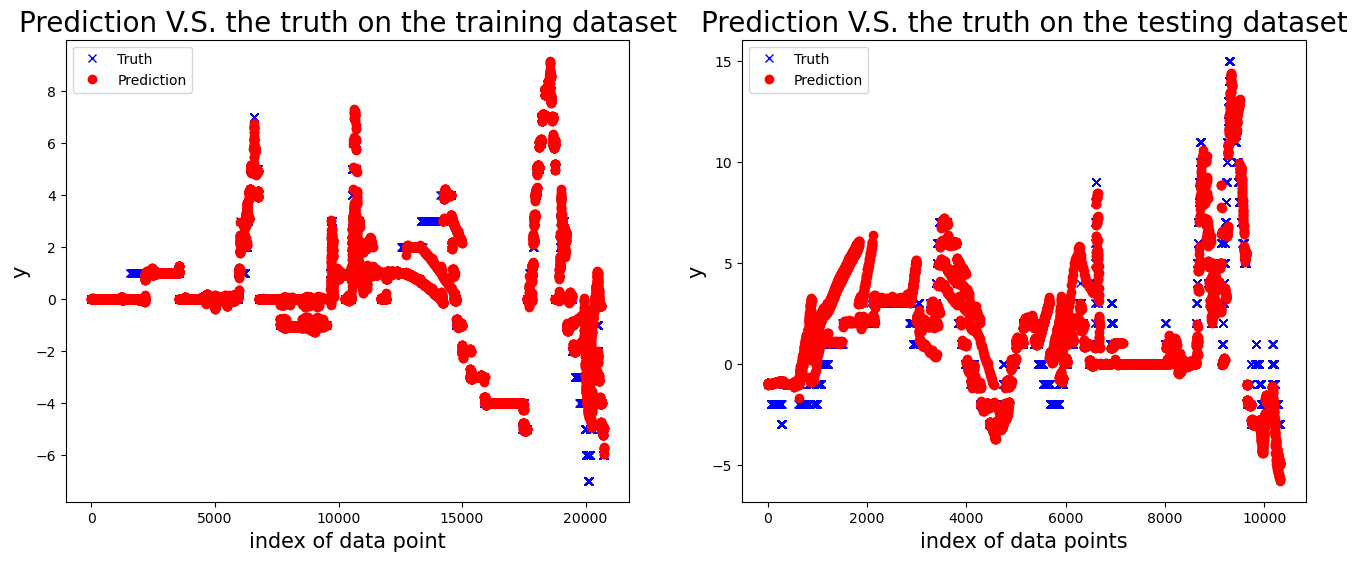

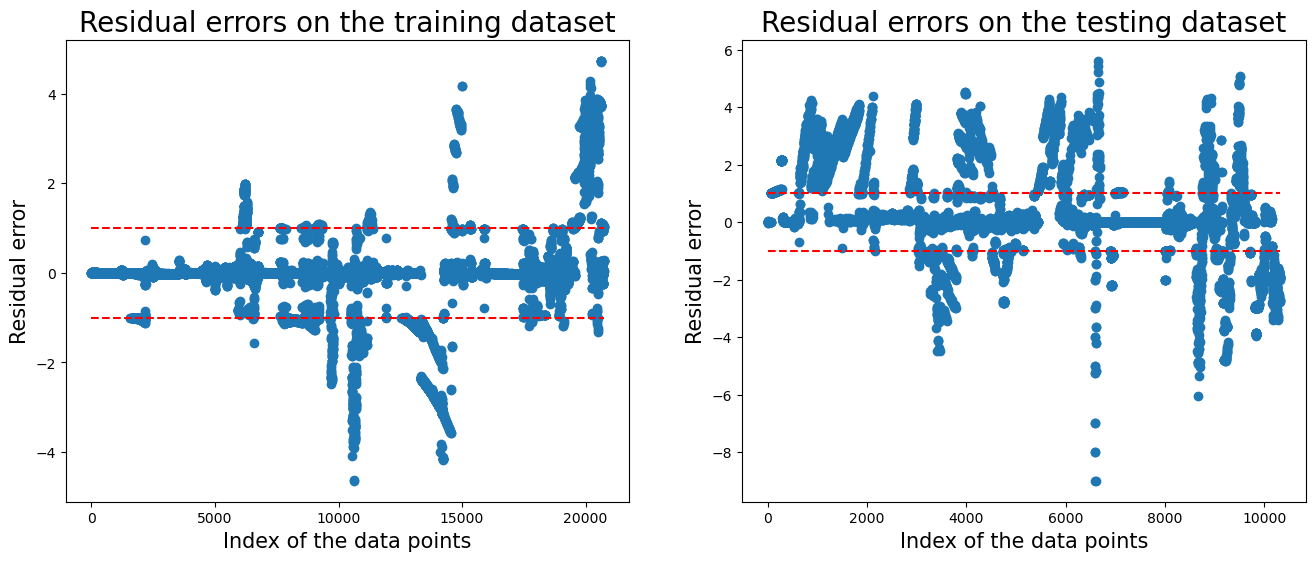

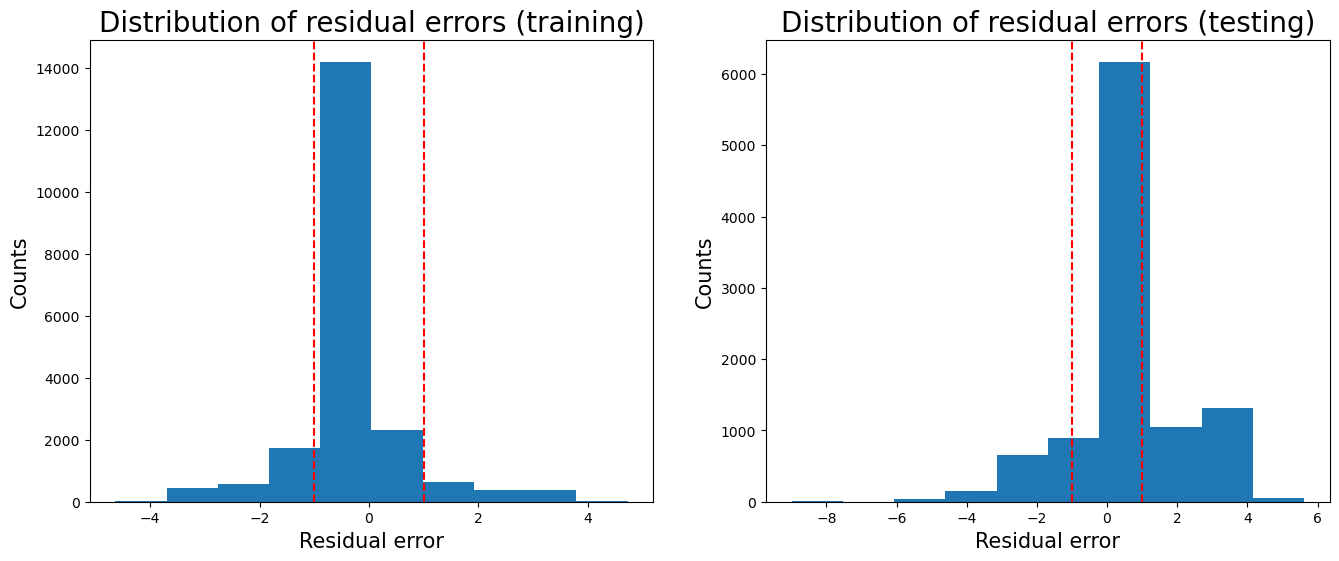


 New cv run:

Training performance, accuracy is: 0.8084305970869103
Training performance, precision is: 0.0
Training performance, recall: 0.0
Training performance, F1: 0.0


Prediction performance, accuracy is: 0.626708014342475
Prediction performance, precision is: 0.27379830348727613
Prediction performance, recall is：0.6014492753623188
Prediction performance, F1 is：0.3762953367875647


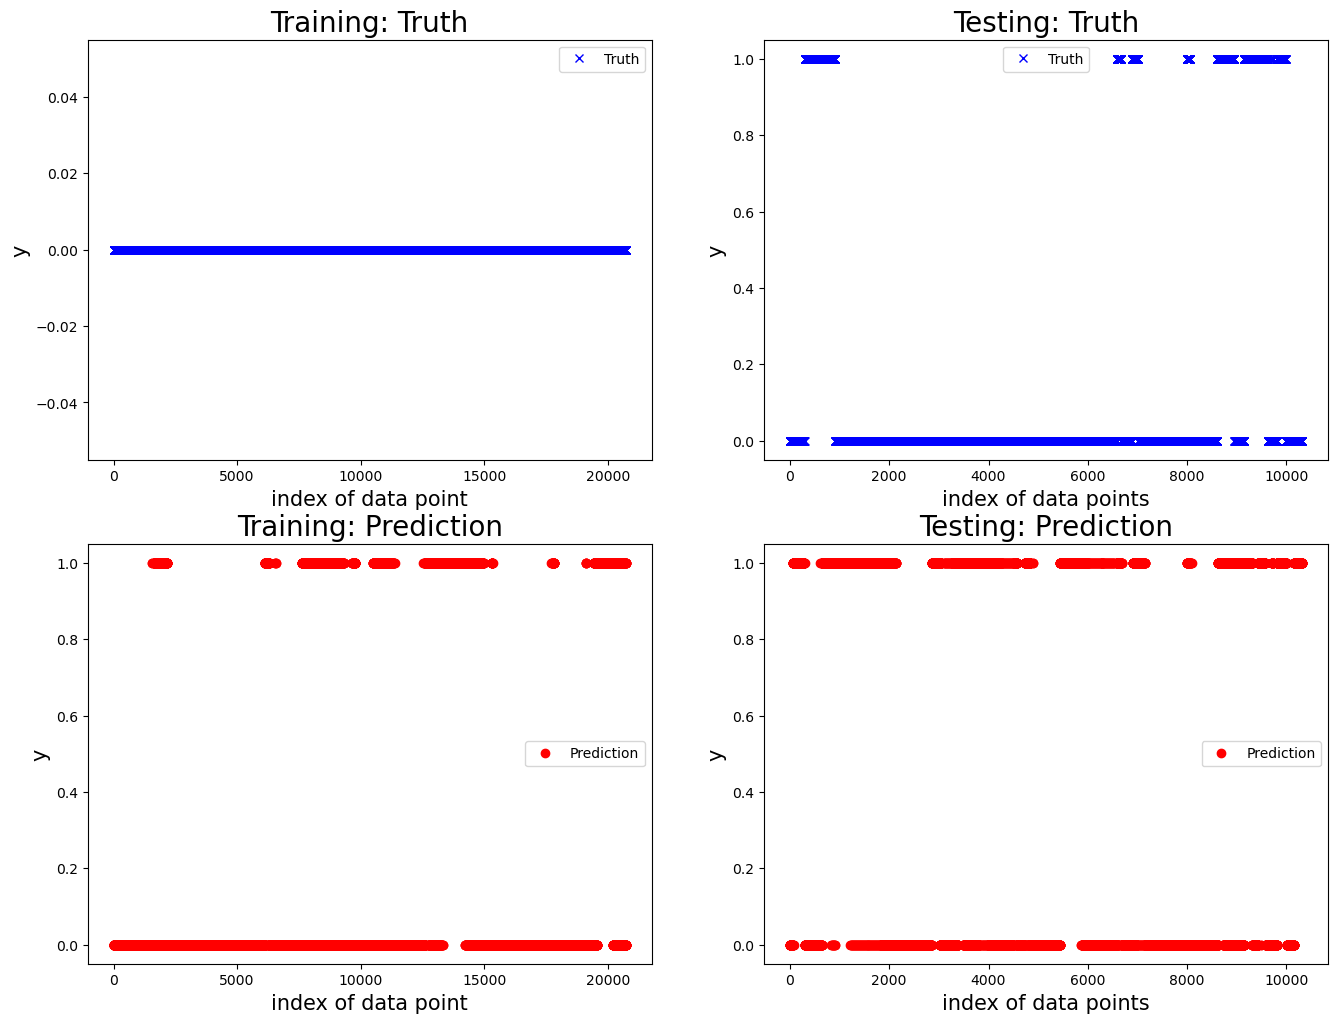

In [20]:
_, y_label_test_org = extract_selected_feature(df_data=df_test, feature_list=feature_list_all, motor_idx=6, mdl_type='clf')
x_test_org, y_temp_test_org = extract_selected_feature(df_data=df_test, feature_list=feature_list_all, motor_idx=6, mdl_type='reg')

# Predict the temperature
threshold = 1
y_label_pred_tr, y_temp_pred_tr = predict_label_by_reg(mdl=mdl, df_x_test=x_tr_org, y_temp_test=y_temp_tr_org, window_size=window_size, 
                            sample_step=sample_step, prediction_lead_time=prediction_lead_time, threshold=threshold)
y_label_pred_tmp, y_temp_pred_tmp = predict_label_by_reg(mdl=mdl, df_x_test=x_test_org, y_temp_test=y_temp_test_org, window_size=window_size, 
                            sample_step=sample_step, prediction_lead_time=prediction_lead_time, threshold=threshold)

# Get the true values.
_, y_label_test = prepare_sliding_window(df_x=x_test_org, y=y_label_test_org, sequence_name_list=test_id, window_size=window_size, sample_step=sample_step, prediction_lead_time=prediction_lead_time, mdl_type='clf')
_, y_temp_test_seq = prepare_sliding_window(df_x=x_test_org, y=y_temp_test_org, sequence_name_list=test_id, window_size=window_size, sample_step=sample_step, prediction_lead_time=prediction_lead_time, mdl_type='reg')


show_reg_result(y_tr=y_temp_tr, y_test=y_temp_test_seq, y_pred_tr=y_temp_pred_tr, y_pred=y_temp_pred_tmp, threshold=threshold)
show_clf_result(y_tr=np.zeros(len(y_label_pred_tr)), y_test=y_label_test, y_pred_tr=y_label_pred_tr, y_pred=y_label_pred_tmp)

# show_reg_result(y_tr=y_temp_tr, y_test=y_temp_test_seq, y_pred_tr=y_temp_tr, y_pred=y_temp_pred_tmp, threshold=threshold)
# show_clf_result(y_tr=np.zeros(1000), y_test=y_label_test, y_pred_tr=np.zeros(1000), y_pred=y_label_pred_tmp)